In [34]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os
%matplotlib inline
np.random.seed(1)

### 1. Load Data

In [35]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [36]:
def load_data():
    num_classes=10
    path = "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/USPS_dataset/usps.h5"
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]
    y_tr = convert_to_onehot(y_tr,num_classes)
    y_te = convert_to_onehot(y_te,num_classes)
    X_tr = np.array(X_tr).reshape(len(X_tr),16,16)
    X_te = np.array(X_te).reshape(len(X_te),16,16)
        
    return X_tr, y_tr, X_te, y_te
    

In [37]:
def load_outlier_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/OutlierTestData/USPS'
    X=[]
    flag = 0
    basedir = ""
    
    for dirName, subdirList, fileList in os.walk(rootDir):
        for fname in fileList:
            img = Image.open( dirName+'/'+fname )
            data = np.array( img, dtype='uint8' )
            X.append(data)
    
    return X

In [38]:
X_train, y_train, X_test, y_test = load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

### 2. Dimension Check


In [39]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
# plt.imshow(X_train[0])

(2007, 16, 16, 1)
(7291, 16, 16, 1)
(2007, 10)
(7291, 10)


In [40]:
X_outlier = load_outlier_data()
X_outlier = np.array(X_outlier)
X_outlier = X_outlier[:,:,:,0][:,:,:,np.newaxis]
print("X_outlier shape: "+ str(X_outlier.shape))

X_outlier shape: (10, 16, 16, 1)


In [41]:
from sys import getsizeof
X_train.nbytes

7465984

### 3 -  Tensorflow Forward Pass


In [42]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [43]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [44]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    

    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')

    A1 = tf.nn.relu(Z1)

    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    A2 = tf.nn.relu(Z2)

    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')

    P2 = tf.contrib.layers.flatten(P2)

    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)


    return Z3

### 6 - Compute Cost

In [45]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [46]:
def get_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    sample = np.random.randint(low=0, high=m, size=m)
    shuffled_X = X[sample]
    shuffled_Y = Y[sample]
    
    for k in range(0, int(m/mini_batch_size)):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [47]:
import time
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 125, minibatch_size = 100, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        tr_start_time = time.time()
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = get_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        save_path = saver.save(sess, "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/USPS/usps.ckpt")
        print("Model saved in path: %s" % save_path)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        tr_end_time = time.time()
        
        te_start_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        te_end_time = time.time()
        print("Training Time: "+ str(tr_end_time - tr_start_time) + " sec")
        print("Train Accuracy:", train_accuracy)
        print("Testing Time: "+ str(te_end_time - te_start_time) + " sec")
        print("Test Accuracy:", test_accuracy)
        outlier_predictions = predict_op.eval(feed_dict={X: X_outlier})

        return outlier_predictions,train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [48]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    outlier_predictions,_, _, parameters = f(*args)
    toc = time.time()
    return outlier_predictions,toc - tic

Cost after epoch 0: 2.344807
Cost after epoch 5: 0.879496
Cost after epoch 10: 0.411493
Cost after epoch 15: 0.309064
Cost after epoch 20: 0.246964
Cost after epoch 25: 0.221312
Cost after epoch 30: 0.187507
Cost after epoch 35: 0.159688
Cost after epoch 40: 0.145214
Cost after epoch 45: 0.151353
Cost after epoch 50: 0.130430
Cost after epoch 55: 0.126879
Cost after epoch 60: 0.115216
Cost after epoch 65: 0.113937
Cost after epoch 70: 0.113719
Cost after epoch 75: 0.097049
Cost after epoch 80: 0.105347
Cost after epoch 85: 0.093634
Cost after epoch 90: 0.094303
Cost after epoch 95: 0.092190
Cost after epoch 100: 0.086135
Cost after epoch 105: 0.082859
Cost after epoch 110: 0.069058
Cost after epoch 115: 0.069798
Cost after epoch 120: 0.080326
Model saved in path: /Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/USPS/usps.ckpt


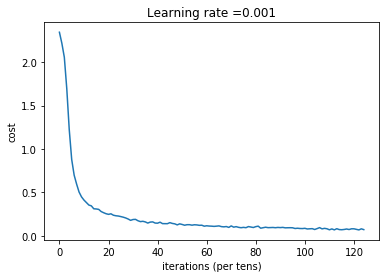

Training Time: 169.81595087051392 sec
Train Accuracy: 0.97956383
Testing Time: 0.226668119430542 sec
Test Accuracy: 0.9272546


In [49]:
outlier_predictions,execution_time = time_function(model, X_train, y_train, X_test, y_test)

In [50]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 171.39403796195984 sec


### 9. Outlier Test


In [52]:
samples_per_class = 10
num_classes = 1
# for i in range(10):
#     plt_idx = i+1
#     plt.subplot(samples_per_class, num_classes, plt_idx)  
#     plt.imshow(X_outlier[i].astype('uint8'))
#     plt.axis('off')
#     i = i+1
# plt.show()

for x in np.nditer(outlier_predictions):
    print(x)

0
8
1
0
1
8
8
1
0
1
